In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stats_df = pd.read_csv("cycles.csv")

In [3]:
ge_tags = ["GE_Solve_Base", "GE_Solve_Loop_Unroll", "GE_Solve_Naive_Vector"]
lu_tags = ["LU_Solve_Basic_C_Opts", "LU_Solve_Transposed", "LU_Solve_Transposed_Vector"]
tri_tags = ["Triangular_System_Solve_Base", "Triangular_System_Solve_Loop_Unroll", "Triangular_System_Solve_Vectorized"]

# the following should all be of same size:
sizes = [] 
ge_perfs_dict = {} # of form [tag : cycles] where |cycles| = |size|
lu_perfs_dict = {} # of form [tag : cycles] where |cycles| = |size|
tri_perfs_dict = {}

In [4]:
# collect_size
sizes = stats_df['size'].sort_values().unique()

In [5]:
def collect_perfs(tag):
    tagged_df = stats_df.loc[stats_df['tag'] == tag].sort_values('size')
    perfs = []
    for index, row in tagged_df.iterrows():
        perfs.append(row['cycles'])
        
    return perfs

In [6]:
for _, f_tag in enumerate(ge_tags):
    ge_perfs_dict[f_tag] = collect_perfs(f_tag)


In [7]:
for _, f_tag in enumerate(lu_tags):
    lu_perfs_dict[f_tag] = collect_perfs(f_tag)

In [8]:
for _, f_tag in enumerate(tri_tags):
    tri_perfs_dict[f_tag] = collect_perfs(f_tag)

/Users/xavier/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


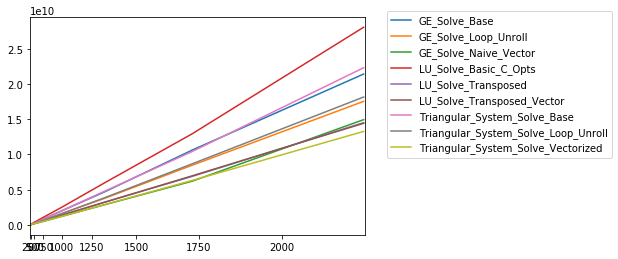

In [9]:
for tag in ge_tags:
    plt.plot(sizes, ge_perfs_dict[tag], label=tag)
for tag in lu_tags:
    plt.plot(sizes, lu_perfs_dict[tag], label=tag)
for tag in tri_tags:
    plt.plot(sizes, tri_perfs_dict[tag], label=tag)

plt.xscale("function", functions=(lambda x: x**(3), lambda x:x**(1/3)))
plt.gca().set_xlim(0, 2200)

# plt.legend(bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
        #    bbox_transform=plt.gcf().transFigure)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()